In [22]:
import pandas as pd
from sodapy import Socrata
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from datetime import datetime

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("health.data.ny.gov", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(health.data.ny.gov,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("xdss-u53e",limit=200000) #limit = 62 counties in NY

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

results_df

,test_date,county,new_positives,cumulative_number_of_positives,total_number_of_tests,cumulative_number_of_tests
0,2020-04-12T00:00:00.000,Albany,21,499,193,5540
1,2020-04-12T00:00:00.000,Allegany,0,26,5,280
2,2020-04-12T00:00:00.000,Bronx,764,22205,1623,43198
3,2020-04-12T00:00:00.000,Broome,7,133,39,948
4,2020-04-12T00:00:00.000,Cattaraugus,0,28,6,370
...,...,...,...,...,...,...
2599,2020-03-02T00:00:00.000,Washington,0,0,0,0
2600,2020-03-02T00:00:00.000,Wayne,0,0,0,0
2601,2020-03-02T00:00:00.000,Westchester,1,1,1,1
2602,2020-03-02T00:00:00.000,Wyoming,0,0,0,0


In [163]:
df_tot_pos = results_df.drop(columns={'total_number_of_tests','cumulative_number_of_tests','new_positives'})
df_daily_pos = results_df.drop(columns={'total_number_of_tests','cumulative_number_of_tests','cumulative_number_of_positives'})

df_tot_tests = results_df.drop(columns={'total_number_of_tests','cumulative_number_of_positives','new_positives'})
df_daily_tests = results_df.drop(columns={'cumulative_number_of_tests','cumulative_number_of_positives','new_positives'})

#make a list of days (no duplicates)
days = results_df['test_date'].drop_duplicates()

In [45]:
#Redo: iloc county column, remove duplicates
#--
#grab counties for any day/drop date column

def reformat(df_in):
    df_temp = df_in.loc[results_df['test_date'] == days.iloc[0]]

    df_temp = df_temp.drop(columns='test_date')
    dft_temp = df_temp.T
    
    dft_temp = dft_temp.reset_index()

    new_header = dft_temp.iloc[0] #grab the first row for the head
    #print(new_header)
#--

#creat df, index as date
    df = pd.DataFrame(columns = new_header)

#loop for each day in date list
    for i in range(len(days)):
        #print(days.iloc[i])
        #data for i-th day
        today = days.iloc[i]
    #print(today)
    
    #get total positive for i-th day from results df
        df_today = df_in.loc[results_df['test_date'] == days.iloc[i]]
        df_today.drop(columns='test_date',inplace=True)
    
        dft = df_today.T
    
        new_header = dft.iloc[0] #grab the first row for the header
        df_temp = dft[1:] #take the data less the header row
        df_temp
        df_temp = df_temp.astype(str).astype(int)
        df_temp.fillna('0', inplace=True)

    
        df_temp.columns = new_header
    
    #df_temp.index.name = 'date'
    #df_temp.rename(index={: "x"},inplace=True)
        df_temp['dates'] = today 
    #print(df_temp)
    #print()
        df = df.append(df_temp,ignore_index = False,sort=True)
    
    #df = df.astype(str).astype(int)
    #df.Erie

#More reformatting
    df.drop(['county'],axis=1,inplace=True)

#make date-time nicer
    df.dates = pd.to_datetime(df.dates, yearfirst = True, format='%Y-%m-%dT%H:%M:%S.%f')
    df.dates = df['dates'].dt.strftime('%m/%d/%Y')

    df.set_index('dates',inplace=True)

    df = df.iloc[1:]

    df["sum"] = df.sum(axis=1)

    df.sort_values('dates',ascending=True,inplace=True)
    
    return df

In [46]:
df_pos = reformat(df_tot_pos)
df_daily_pos = reformat(df_daily_pos)

df_test = reformat(df_tot_tests)
df_daily_test = reformat(df_daily_tests)

In [114]:
#top 10 counties
dft = df_pos.T
dft
#dft.iloc[0,:]
today = len(dft.columns)-1
df_top = dft.sort_values(dft.columns[today], ascending = False)
df_top.head(13) #Buffalo/Erie is 13th!

dates,03/02/2020,03/03/2020,03/04/2020,03/05/2020,03/06/2020,03/07/2020,03/08/2020,03/09/2020,03/10/2020,03/11/2020,...,04/02/2020,04/03/2020,04/04/2020,04/05/2020,04/06/2020,04/07/2020,04/08/2020,04/09/2020,04/10/2020,04/11/2020
sum,1,1,3,25,36,60,88,151,195,251,...,102863,113704,122031,130689,138863,149316,159937,170512,180458,188694
Queens,0,0,0,1,2,2,3,3,7,12,...,18167,20114,21436,23133,24840,26248,27752,29303,31291,32835
Kings,0,0,1,1,4,4,6,7,14,16,...,15700,17504,18558,19702,20879,22082,23394,24715,26243,27471
Nassau,0,0,0,1,4,6,10,14,20,31,...,12024,13346,14398,15616,16610,18548,20140,21512,22584,23553
Bronx,0,0,0,0,0,0,1,5,5,7,...,11086,12315,13368,14327,15348,16626,17792,19160,20477,21441
Suffolk,0,0,0,0,0,0,1,1,6,11,...,10154,11370,12405,13487,14517,15844,17413,18692,19883,20816
Westchester,1,1,1,20,20,42,60,102,111,132,...,12351,13081,13723,14294,14804,15887,17004,18077,18729,19313
New York,0,0,1,2,5,5,5,12,24,27,...,8452,9300,9898,10440,11012,11504,12106,12722,13437,14145
Rockland,0,0,0,0,1,1,1,4,4,6,...,4289,4872,5326,5703,5990,6413,6665,7122,7477,7721
Richmond,0,0,0,0,0,0,0,0,1,2,...,3754,4073,4291,4579,4797,5343,5984,6484,6860,7316


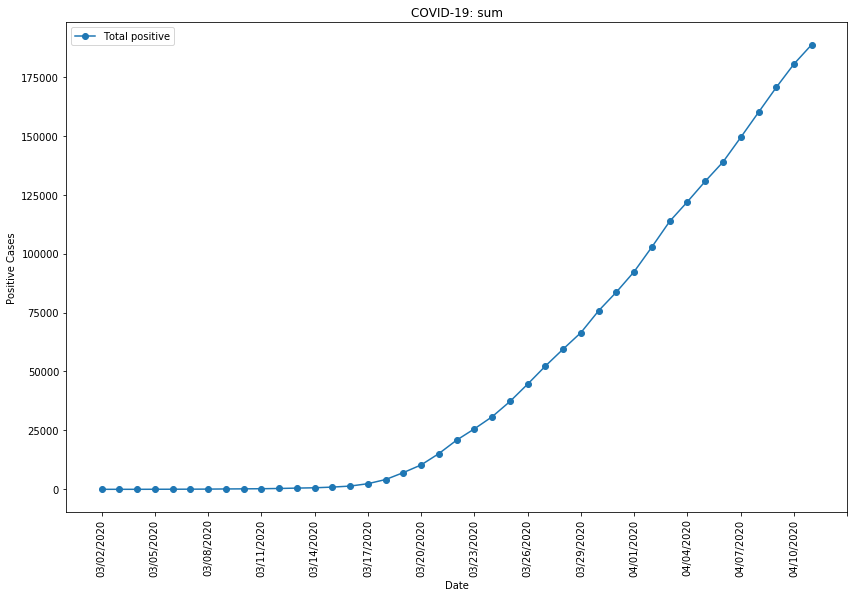

In [160]:
plt.figure(figsize=(14,9))

state = 'sum'
plt.plot_date(df_pos.index,df_pos[state].values,label='Total positive',ls='-')
#plt.plot_date(df.dates,df.Bronx.values,label='Bronx',ls='-')


plt.xticks(rotation='vertical')
ax=plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
plt.title('COVID-19: '+str(state))
plt.ylabel('Positive Cases')
plt.xlabel('Date')
leg = plt.legend();
plt.show()

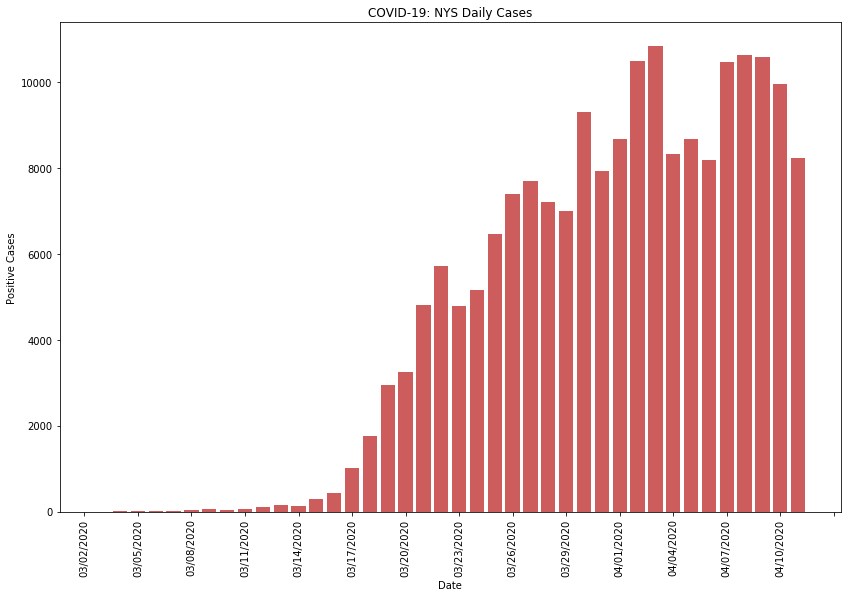

In [159]:
diff = df.diff()
#can also use df_daily_pos

plt.figure(figsize=(14,9))

#plt.bar(df.index, df['Erie'].values)
plt.bar(diff.index, diff['sum'].values,color='indianred')

#ax.xaxis_date()
plt.xticks(rotation='vertical')
plt.title('COVID-19: NYS Daily Cases')
plt.ylabel('Positive Cases')
plt.xlabel('Date')
ax=plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
plt.show()

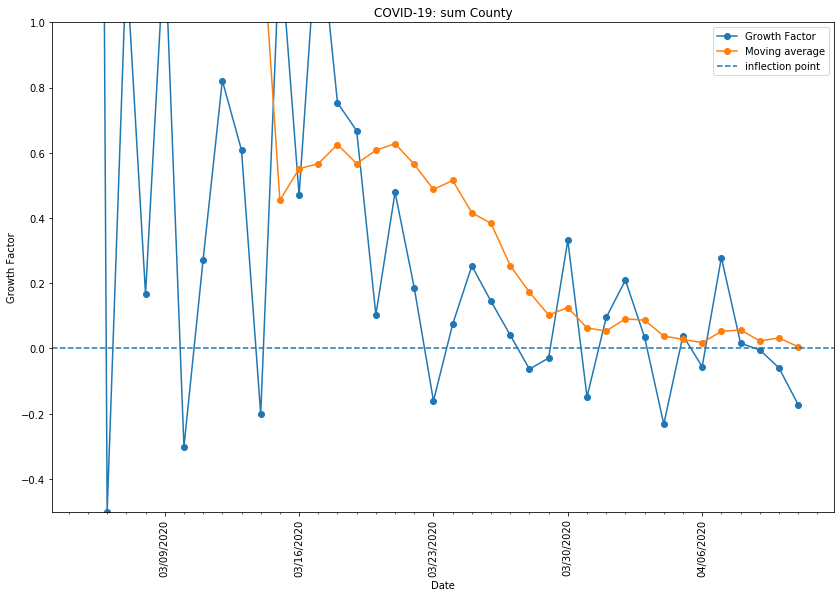

In [170]:
window = 10
state = 'sum'

diff = df.diff()
gf = diff.pct_change()
rol = gf.rolling(window).sum()/window

plt.figure(figsize=(14,9))

plt.plot_date(gf.index,gf[state].values,label='Growth Factor',ls='-')
plt.plot_date(rol.index,rol[state].values,label='Moving average',ls='-')


plt.xticks(rotation='vertical')
plt.title('COVID-19: '+str(state)+' County')
plt.ylabel('Growth Factor')
plt.xlabel('Date')

ax=plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

plt.axhline(0,ls='--',label='inflection point')
leg = plt.legend();
plt.ylim([-0.5, 1])

plt.show()

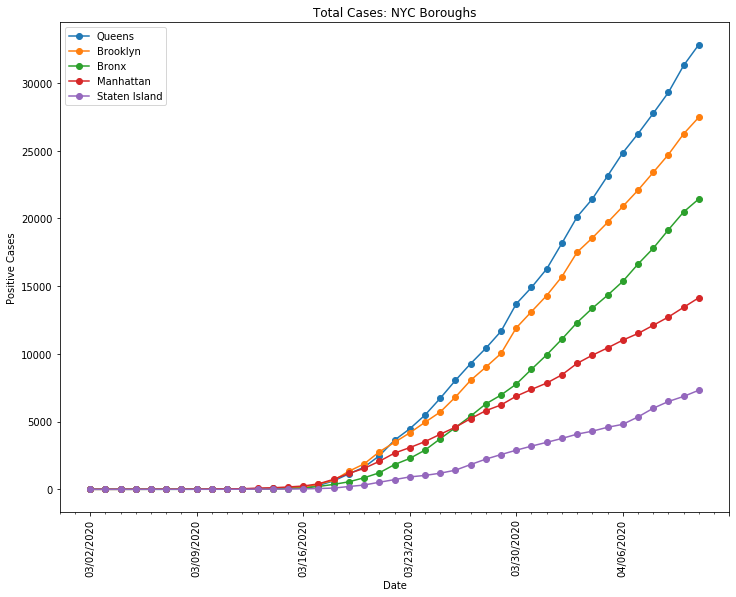

In [8]:
plt.figure(figsize=(12,9))
ax=plt.gca()
#plt.plot_date(df.index,df.Bronx.values,label='Bronx',ls='-')
plt.plot_date(df.index,df['Queens'].values,label='Queens',ls='-')
plt.plot_date(df.index,df['Kings'].values,label='Brooklyn',ls='-')

plt.plot_date(df.index,df['Bronx'].values,label='Bronx',ls='-')
plt.plot_date(df.index,df['New York'].values,label='Manhattan',ls='-')

plt.plot_date(df.index,df['Richmond'].values,label='Staten Island',ls='-')

plt.title('Total Cases: NYC Boroughs')
plt.ylabel('Positive Cases')
plt.xlabel('Date')
leg = plt.legend();

ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.xticks(rotation='vertical')
ax=plt.gca()
plt.show()

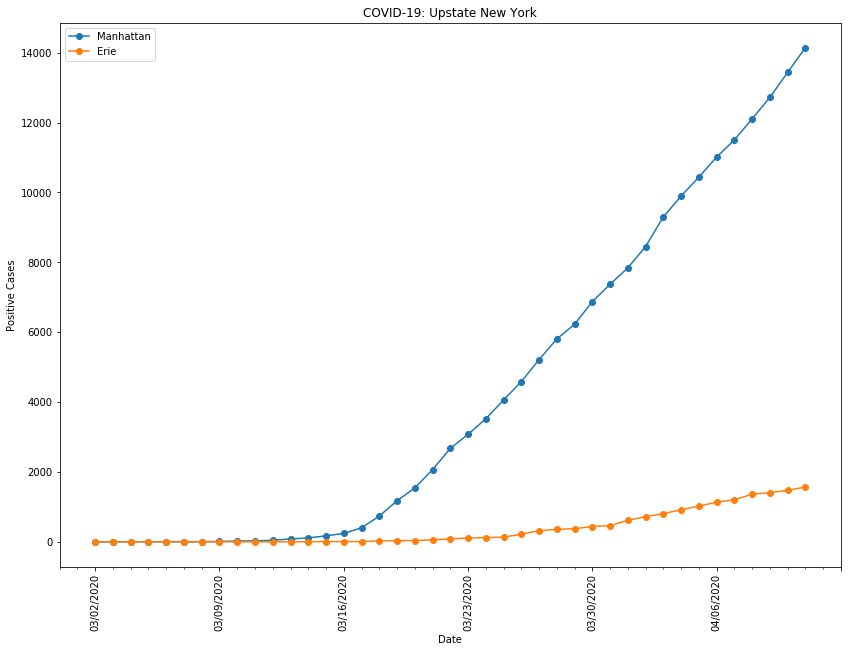

In [10]:
plt.figure(figsize=(14,10))

plt.plot_date(df.index,df['New York'].values,label='Manhattan',ls='-')
plt.plot_date(df.index,df.Erie.values,label='Erie',ls='-')


plt.title('COVID-19: Upstate New York')
plt.ylabel('Positive Cases')
plt.xlabel('Date')
leg = plt.legend();

ax=plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

plt.xticks(rotation='vertical')

plt.show()